In [4]:
%load_ext autoreload
%autoreload 2

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [372]:
def plot_miscoverage_examples(test_dataset, coverages, intervals):
    miscovered_idx = torch.nonzero(~coverages, as_tuple=False)[:, 0].tolist()
    fig, axs = plt.subplots(5, 2, figsize=(10, 10), sharey=True)

    for ax in axs.flat:
        i = np.random.choice(miscovered_idx)
        ax.fill_between(range(test_dataset[i][1].size(0)),
                         intervals[i, 0].flatten().tolist(), 
                         intervals[i, 1].flatten().tolist(), 
                         color="r", alpha=0.25)
        ax.plot(intervals[i, 0].flatten().tolist(), linestyle="--", color="r")
        ax.plot(intervals[i, 1].flatten().tolist(), linestyle="--", color="r")
        ax.plot((intervals[i, 0] + (intervals[i, 1] - intervals[i, 0]) / 2).flatten().tolist(), linestyle="--", linewidth=3, color="r")

        ax.scatter(range(test_dataset[i][1].size(0)), test_dataset[i][1].flatten().tolist(), color="black")

        ax.set(xlabel='Time step', ylabel='Prediction')
    plt.show()

## Generate datasets

In [407]:
noise_profiles = [[0.2] * 20 + [0.6] * 20 + [1.2] * 20 + [1.6] * 20 + [2.4] * 20 + [3.0] * 20]


In [577]:
from utils.make_data import generate_autoregressive_forecast_dataset
train_dataset = generate_autoregressive_forecast_dataset(n_samples=1000, seq_len=100, horizon=20, periodicity=10)
calibration_dataset = generate_autoregressive_forecast_dataset(n_samples=1000, seq_len=100, horizon=20, periodicity=10)
test_dataset = generate_autoregressive_forecast_dataset(n_samples=500, seq_len=100, horizon=20, periodicity=10)

# ar, noise, periodic = generate_autoregressive_forecast_dataset(n_samples=100, seq_len=100, horizon=20, periodicity=10)


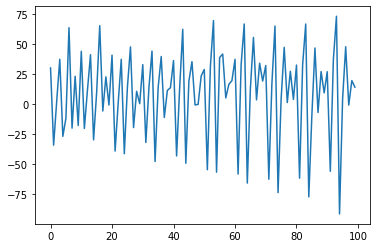

In [570]:
for sequence, target, _ in train_dataset:
    plt.plot(sequence)
    break

## Conformal forecaster

In [574]:
from models.conformal import ConformalForecaster
model = ConformalForecaster(embedding_size=8, horizon=20, error_rate=0.05)
model.fit(train_dataset, calibration_dataset, epochs=, lr=0.001, batch_size=32)

Epoch: 0	Train loss: 1165.639907836914
Epoch: 50	Train loss: 1360.2777709960938
Epoch: 100	Train loss: 1224.1039123535156
Epoch: 150	Train loss: 1195.8392639160156
Epoch: 200	Train loss: 1243.2097473144531
Epoch: 250	Train loss: 1151.2867279052734


In [575]:
coverages, intervals = model.evaluate_coverage(test_dataset)
print('% of series within predicted intervals: {}'.format(torch.mean(coverages.float(), dim=0).item()))

% of series within predicted intervals: 0.8399999737739563


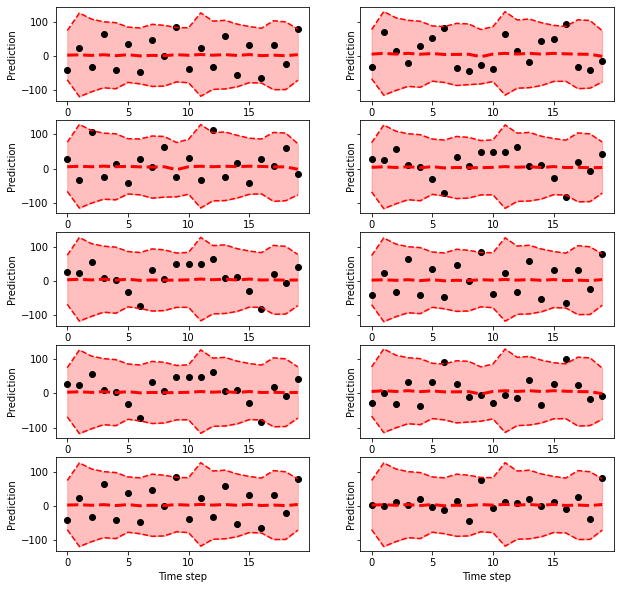

In [576]:
plot_miscoverage_examples(test_dataset, coverages, intervals)

## Shorter training intervals

Set `seq_len=10` and predict for horizon of 10 time steps.

In [429]:
train_dataset_short = generate_autoregressive_forecast_dataset(n_samples=1000, seq_len=20, horizon=10)
calibration_dataset_short = generate_autoregressive_forecast_dataset(n_samples=1000, seq_len=20, horizon=10)
test_dataset_short = generate_autoregressive_forecast_dataset(n_samples=500, seq_len=20, horizon=10)

In [430]:
model_short = ConformalForecaster(embedding_size=8, horizon=10, error_rate=0.05)

In [431]:
model_short.fit(train_dataset_short, calibration_dataset_short, epochs=100, lr=0.01, batch_size=100)
coverages_short, intervals_short = model_short.evaluate_coverage(test_dataset_short)
print('% of series within predicted intervals: {}'.format(torch.mean(coverages_short.float(), dim=0).item()))

Epoch: 0	Train loss: 99.04461441040038
Epoch: 50	Train loss: 14.646926784515381
% of series within predicted intervals: 0.9599999785423279


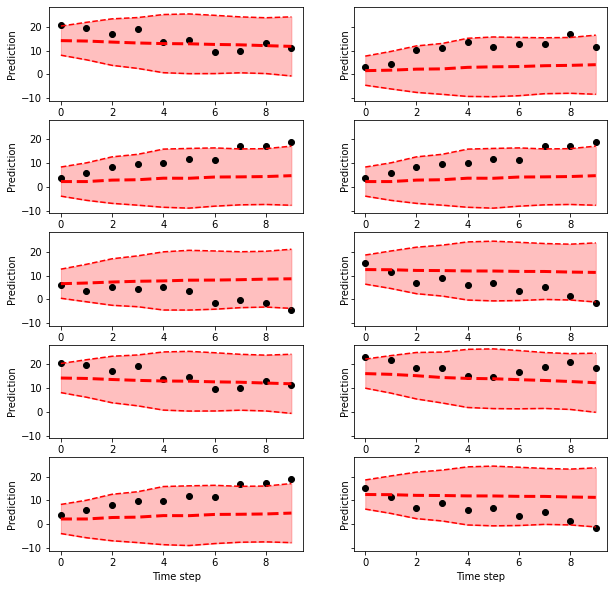

In [432]:
plot_miscoverage_examples(test_dataset_short, coverages_short, intervals_short)

In [468]:
def seasonality(duration, periodicity, harmonics=None):
    noise_std = 1.
    harmonics = harmonics if harmonics else int(np.floor(periodicity / 2))

    lambda_p = 2 * np.pi / float(periodicity)

    gamma_jt = noise_std * np.random.randn(harmonics)
    gamma_star_jt = noise_std * np.random.randn(harmonics)

    total_timesteps = 100 * duration  # Pad for burn in
    series = np.zeros(total_timesteps)
    for t in range(total_timesteps):
        gamma_jtp1 = np.zeros_like(gamma_jt)
        gamma_star_jtp1 = np.zeros_like(gamma_star_jt)
        for j in range(1, harmonics + 1):
            cos_j = np.cos(lambda_p * j)
            sin_j = np.sin(lambda_p * j)
            gamma_jtp1[j - 1] = (gamma_jt[j - 1] * cos_j
                                 + gamma_star_jt[j - 1] * sin_j
                                 + noise_std * np.random.randn())
            gamma_star_jtp1[j - 1] = (- gamma_jt[j - 1] * sin_j
                                      + gamma_star_jt[j - 1] * cos_j
                                      + noise_std * np.random.randn())
        series[t] = np.sum(gamma_jtp1)
        gamma_jt = gamma_jtp1
        gamma_star_jt = gamma_star_jtp1

    return series[-duration:]  # Discard burn in

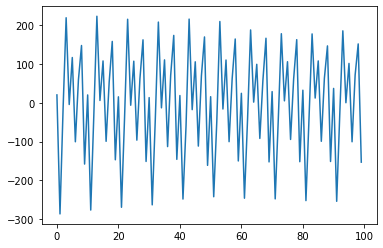

In [470]:
plt.plot(seasonality(100, 10))

In [500]:
len(seasonality(100, 10))

100

In [522]:
ar = [1,2,3]
noise=[4,5,6]
sea  =[7,8,9]

for i,j,k in zip(ar, noise, sea):
    print(i,j,k)

1 4 7
2 5 8
3 6 9
